# 1.0 Setup

Ensure that your Jupyter environment is setup correctly and import all of the data science libraries that we will need.  If some modules are missing, we will attempt to install the library but it is usually a better practice to install it in your environment directly.

Also, if the data is missing, we will attempt to download it (from github) and put it in the "data" directory.

In [210]:
# Import required modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mplot
%matplotlib inline
import IPython
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from distutils.version import StrictVersion
print("numpy version:  %s" % np.__version__)
print("pandas version:  %s" % pd.__version__)
print("matplotlib version:  %s" % mplot.__version__)
print("IPython version:  %s" % IPython.__version__)
print("seaborn version:  %s" % sns.__version__)

if StrictVersion(np.__version__) >= StrictVersion('1.13.0') and \
   StrictVersion(pd.__version__) >= StrictVersion('0.20.0') and \
   StrictVersion(mplot.__version__) >= StrictVersion('2.0.0') and \
   StrictVersion(IPython.__version__) >= StrictVersion('5.5.0') and \
   StrictVersion(sns.__version__) >= StrictVersion('0.7.0'):
    print('\nCongratulations, your environment is setup correctly!')
else:
    print('\nEnvironment is NOT setup correctly!')


numpy version:  1.14.0
pandas version:  0.22.0
matplotlib version:  2.1.2
IPython version:  6.2.1
seaborn version:  0.8.1

Congratulations, your environment is setup correctly!


In [211]:
# Try to install the Excel reader library

try:
    import xlrd
    print('The Excel library is installed.')
except ImportError:
    print('Installing the Excel library')
    !pip install xlrd
    import xlrd

The Excel library is installed.


In [212]:
# Find the data directory and download data if it is missing

import os, shutil
cwd = os.getcwd()
datadir = cwd + '/data'

print('Data directory is: {}'.format(datadir))

Data directory is: /Users/stevej/spark/dswg/data


In [213]:
# See if the data exists.  If not, try to download it from github.
if not os.path.exists(datadir):
    print("Data directory doesn't exist!")
    # Checkout the data from Github
    !git clone https://github.com/stevejohnson2001/dswg
    shutil.move('dswg/data','.')
    shutil.rmtree('dswg')
print('Data directory contains:\n',os.listdir(datadir))


Data directory contains:
 ['medications.csv', 'allergies.csv', 'procedures.csv', 'conditions.csv', 'careplans.csv', 'encounters.csv', 'immunizations.csv', 'AllPrescribableOpioidsUsedForPainControlIncludingInactiveMedications.xlsx', 'patients.csv', 'observations.csv']


# 2.0 Read in the data

Now that we have all the libraries installed and the data is available, lets try to read it into Pandas DataFrames.  

The first thing we will do is define a Data Dictionary (dd) that describes our expectations for the data.  It includes data types for the columns as well is information about whether the column is required or optional.  The data is read into a dictionary of Dataframes (data) and also assigned to  variables (patients, encounters, etc) for convenience.

We will convert dates and other fields to the proper format when later when we do data preparation.

The dataset is synthetic data generated by the Synthea project (https://github.com/synthetichealth/synthea).  Synthea creates realistic (but not real) EHR-like data that we can use for demonstrating the techniques of data science.

In [214]:
# Read in the data
dd = {}

dd['patients'] = {'pat_id':     {'type': np.str, 'required':True},  
                  'birth_date': {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                  'death_date': {'type': np.datetime64, 'format': '%Y-%m-%d' }, 
                  'ssn':        {'type': np.str},
                  'drivers':    {'type': np.str},
                  'passport':   {'type': np.str},
                  'prefix':     {'type': np.str},
                  'first':      {'type': np.str, 'required':True},
                  'last':       {'type': np.str, 'required':True},
                  'suffix':     {'type': np.str},
                  'maiden':     {'type': np.str},
                  'marital':    {'type': np.str},
                  'race':       {'type': np.str},
                  'ethnicity':  {'type': np.str},
                  'gender':     {'type': np.str, 'required':True},
                  'birthplace': {'type': np.str},
                  'address':    {'type': np.str, 'required':True},
                  'prior_opioid_abuse_diag': {'type': np.int}
                  }
dd['encounters'] = {'enc_id':                 {'type': np.str, 'required':True}, 
                    'enc_date':               {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                    'enc_pat_id':             {'type': np.str, 'required':True},
                    'enc_code':               {'type': np.str, 'required':True},
                    'enc_description':        {'type': np.str, 'required':True},
                    'enc_reason_code':        {'type': np.str},
                    'enc_reason_description': {'type': np.str}
                   }
dd['observations'] = {'obs_date':        {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                      'obs_pat_id':      {'type': np.str, 'required':True},
                      'obs_enc_id':      {'type': np.str, 'required':True},
                      'obs_code':        {'type': np.str, 'required':True},
                      'obs_description': {'type': np.str, 'required':True},
                      'obs_value':       {'type': np.str},
                      'obs_units':       {'type': np.str}
                     }
dd['medications'] = {'med_start_date':         {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                     'med_stop_date':          {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':False},
                     'med_pat_id':             {'type': np.str, 'required':True},
                     'med_enc_id':             {'type': np.str, 'required':True},
                     'med_code':               {'type': np.str, 'required':True},
                     'med_description':        {'type': np.str, 'required':True},
                     'med_reason_code':        {'type': np.str},
                     'med_reason_description': {'type': np.str},
                     'med_days_supply':        {'type': np.int}
                     }
dd['conditions'] =  {'cond_start_date':         {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':True},
                     'cond_stop_date':          {'type': np.datetime64, 'format': '%Y-%m-%d', 'required':False},
                     'cond_pat_id':             {'type': np.str, 'required':True},
                     'cond_enc_id':             {'type': np.str, 'required':True},
                     'cond_code':               {'type': np.str, 'required':True},
                     'cond_description':        {'type': np.str, 'required':True}
                     }


# Display the data dictionary

for name, tbl_dd in dd.items():
    display(HTML('<h2>{}</h2>'.format(name)))
    display(pd.DataFrame(tbl_dd).fillna('').T)

,format,required,type
address,,True,<class 'str'>
birth_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
birthplace,,,<class 'str'>
death_date,%Y-%m-%d,,<class 'numpy.datetime64'>
drivers,,,<class 'str'>
ethnicity,,,<class 'str'>
first,,True,<class 'str'>
gender,,True,<class 'str'>
last,,True,<class 'str'>
maiden,,,<class 'str'>


,format,required,type
enc_code,,True,<class 'str'>
enc_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
enc_description,,True,<class 'str'>
enc_id,,True,<class 'str'>
enc_pat_id,,True,<class 'str'>
enc_reason_code,,,<class 'str'>
enc_reason_description,,,<class 'str'>


,format,required,type
obs_code,,True,<class 'str'>
obs_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
obs_description,,True,<class 'str'>
obs_enc_id,,True,<class 'str'>
obs_pat_id,,True,<class 'str'>
obs_units,,,<class 'str'>
obs_value,,,<class 'str'>


,format,required,type
med_code,,True,<class 'str'>
med_days_supply,,,<class 'int'>
med_description,,True,<class 'str'>
med_enc_id,,True,<class 'str'>
med_pat_id,,True,<class 'str'>
med_reason_code,,,<class 'str'>
med_reason_description,,,<class 'str'>
med_start_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
med_stop_date,%Y-%m-%d,False,<class 'numpy.datetime64'>


,format,required,type
cond_code,,True,<class 'str'>
cond_description,,True,<class 'str'>
cond_enc_id,,True,<class 'str'>
cond_pat_id,,True,<class 'str'>
cond_start_date,%Y-%m-%d,True,<class 'numpy.datetime64'>
cond_stop_date,%Y-%m-%d,False,<class 'numpy.datetime64'>


In [215]:
data = {}
                    
# Loop through each of the file defintions in our data dictionary
for f in dd:
    m = dd[f]
    col_names = list(m.keys())
    data[f] = pd.read_csv(datadir + '/{}.csv'.format(f), dtype=str, index_col=False, header=0, names=col_names, keep_default_na=False)
    
patients = data['patients']
encounters = data['encounters']
observations = data['observations']
medications = data['medications']
conditions = data['conditions']

### Load the list of opioid medications

It will be important to know which of the medications that are prescribed are considered opioids.  The UMLS VSAC maintains value set lists of which medications are considered opioids.  You can download the current list by going to https://vsac.nlm.nih.gov/ and searching for opioid value sets.  We have downloaded the list called "All prescribable opioids used for pain control including Inactive Medications" (oid 1.3.6.1.4.1.6997.4.1.2.234.999.3.2) into the data directory.  We will read the Excel file and pull out the codes from the second sheet in the file.

In [216]:
# Get Opioid code list from VSAC
# oid 1.3.6.1.4.1.6997.4.1.2.234.999.3.2
xl = pd.ExcelFile(datadir + '/AllPrescribableOpioidsUsedForPainControlIncludingInactiveMedications.xlsx')
df = xl.parse("Code List", skiprows=12)
display(df.head(10))
opioids_rxnorm = list(df['Code'].astype(np.str))  # Make sure the codes are treated as strings


#TODO opioids_rxnorm = ['1049369','1310197','1049544']

,Code,Description,Code System,Code System Version,Code System OID,TTY
0,1010600,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
1,1010603,Buprenorphine 2 MG / Naloxone 0.5 MG Oral Stri...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
2,1010604,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
3,1010606,Buprenorphine 8 MG / Naloxone 2 MG Oral Strip ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
4,1010608,Buprenorphine 2 MG / Naloxone 0.5 MG Sublingua...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
5,1010609,Buprenorphine 8 MG / Naloxone 2 MG Sublingual ...,RXNORM,2018-04,2.16.840.1.113883.6.88,SBD
6,1014599,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
7,1014615,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
8,1014632,Acetaminophen 300 MG / Oxycodone Hydrochloride...,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD
9,102492,Heroin 0.6 MG/ML Oral Solution,RXNORM,2018-04,2.16.840.1.113883.6.88,SCD


# 3.0 Exploratory Data Analysis - Part 1

Start by looking at the data to see what types of values are in each variables, the relationships and get a feel for the data.

## Start by display the data as Dataframes

Displaying the first 5 rows of the data is a good way to look for obvious issues before working with the data in more detail.


In [217]:
# Loop through each of the file defintions in our data dictionary
for f in dd:
    m = dd[f]
    display(HTML('<h3>{}, {} records</h3>'.format(f,len(data[f]))))
    display(data[f].head(5))

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
0,0a549323-9e08-4843-a61b-d9e0bbf6af72,2017-10-01,,999-52-5697,,,,Gustavo235,Yáñez198,,,,black,west_indian,M,St. Paul,359 Kshlerin Well Stillwater Minnesota 55082 US,0
1,e69c498f-5d81-4f75-b6d7-9cec430944d8,2016-02-11,,999-63-6817,,,,Ok556,Bruen238,,,,white,italian,F,Medford,802 Purdy Dale Bernadotteship Minnesota US,1
2,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,1966-03-29,,999-12-4462,S99992290,X53627396X,Mr.,Gilberto712,Willms744,,,M,white,french,M,Richfield,334 Ward Byway Albanyship Minnesota US,1
3,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,1961-03-01,,999-95-8614,S99994151,X30227522X,Mrs.,Dion244,Aufderhar910,,Johnston597,M,white,english,F,Brooklyn Park,900 Feeney Terrace Apt 32 Maplewood Minnesota ...,0
4,d1a2a94d-19b2-4f3e-a731-40e1972c2c8f,1961-04-29,,999-85-8755,S99993315,X20660988X,Mr.,Raleigh478,Hilll811,,,M,asian,chinese,M,Ham Lake,167 Jaskolski Alley St. Paul Minnesota 55101 US,0


,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
0,cc550fce-3901-4c73-b66d-1c28d94f7f74,2017-10-01,0a549323-9e08-4843-a61b-d9e0bbf6af72,185349003,Encounter for check up (procedure),,
1,59b7e22d-12cb-4d4e-a4ae-1523926c7d93,2017-11-05,0a549323-9e08-4843-a61b-d9e0bbf6af72,185349003,Encounter for check up (procedure),,
2,801fff8f-8536-4053-8d38-afc7cf4eb6b0,2018-01-07,0a549323-9e08-4843-a61b-d9e0bbf6af72,185349003,Encounter for check up (procedure),,
3,21550272-2388-4f4e-b5e9-ea63cc7b330c,2018-03-11,0a549323-9e08-4843-a61b-d9e0bbf6af72,185349003,Encounter for check up (procedure),,
4,4a7fb406-f8b6-4247-adaa-546c5d9c2838,2016-02-11,e69c498f-5d81-4f75-b6d7-9cec430944d8,185349003,Encounter for check up (procedure),,


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units
0,2017-10-01,0a549323-9e08-4843-a61b-d9e0bbf6af72,cc550fce-3901-4c73-b66d-1c28d94f7f74,8302-2,Body Height,53.4,cm
1,2017-10-01,0a549323-9e08-4843-a61b-d9e0bbf6af72,cc550fce-3901-4c73-b66d-1c28d94f7f74,29463-7,Body Weight,4.8,kg
2,2017-11-05,0a549323-9e08-4843-a61b-d9e0bbf6af72,59b7e22d-12cb-4d4e-a4ae-1523926c7d93,8302-2,Body Height,53.4,cm
3,2017-11-05,0a549323-9e08-4843-a61b-d9e0bbf6af72,59b7e22d-12cb-4d4e-a4ae-1523926c7d93,29463-7,Body Weight,4.8,kg
4,2017-11-05,0a549323-9e08-4843-a61b-d9e0bbf6af72,59b7e22d-12cb-4d4e-a4ae-1523926c7d93,8462-4,Diastolic Blood Pressure,77.1,mmHg


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description,med_days_supply
0,2013-10-30,2013-11-06,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,e3a4b985-cd7f-4b90-a55a-df0a1d6f39a4,824184,Amoxicillin 250 MG / Clavulanate 125 MG [Augme...,444814009,Viral sinusitis (disorder),4
1,2008-10-11,2009-10-06,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,68746c4e-9d6f-4741-9e3e-65e0fa2e5f1a,757594,Jolivette 28 Day Pack,,,2
2,2009-10-06,2010-10-01,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,225ce1a9-724d-4902-85d0-02e7054da6cd,757594,Jolivette 28 Day Pack,,,2
3,2014-12-21,2015-01-11,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,20a7bb03-b4b2-43ef-9397-91219363f6d3,308192,Amoxicillin 500 MG Oral Tablet,,,3
4,2014-12-21,2015-01-06,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,20a7bb03-b4b2-43ef-9397-91219363f6d3,857005,Acetaminophen 325 MG / HYDROcodone Bitartrate ...,,,3


,cond_start_date,cond_stop_date,cond_pat_id,cond_enc_id,cond_code,cond_description
0,2008-08-19,2008-09-02,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,fc357fc8-0dd1-48db-b558-e80939d9ff74,444814009,Viral sinusitis (disorder)
1,2013-01-14,2013-01-28,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,9786d10c-c251-4f3b-a845-3896dc407d09,444814009,Viral sinusitis (disorder)
2,2013-10-30,2013-11-06,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,e3a4b985-cd7f-4b90-a55a-df0a1d6f39a4,444814009,Viral sinusitis (disorder)
3,2016-03-29,2017-03-24,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,8645695b-b1dd-4059-b013-dc95819e265e,68496003,Polyp of colon
4,2016-09-17,2016-09-27,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,a03c7cc8-ccc6-4dcc-a4aa-9edbc1d0c7c0,195662009,Acute viral pharyngitis (disorder)


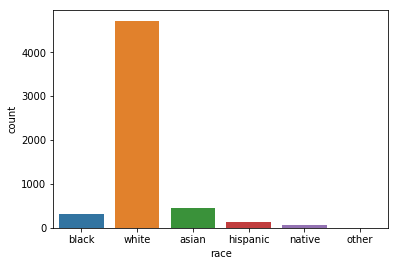

In [218]:
# Look at the categorical variables

sns.countplot(x='race', data=patients)

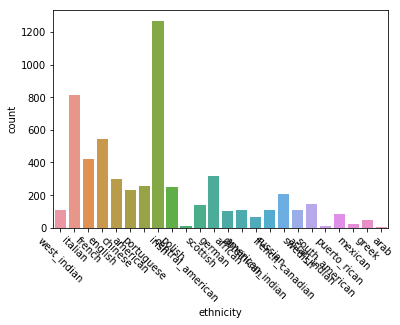

In [219]:
g = sns.countplot(x='ethnicity', data=patients)
z = plt.xticks(rotation=-45)

Average weight:  71.1679266502721


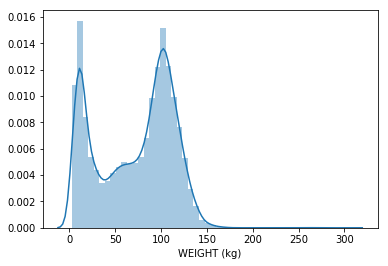

In [220]:
# For continuous variables, we can graph the distribution

w = observations[observations['obs_code']=='29463-7']   # Find all of the "weight" observations
weights = w['obs_value'].astype(np.float)
mean = np.mean(weights)
print('Average weight: ',mean)

# Plot the distribution
sns.distplot(weights)
plt.xlabel("WEIGHT (kg)")
plt.show()   # If you don't explicitly "show" the plot, Jupyter will automatically show the last plot

In [221]:
# As an Exercise, have participants graph the Height of patients



# 4.0 Data Preparation

Now that we know a little about our data, we can begin to prepare it for analysis.  We need to:
1. Find data that is not formatted correctly
2. Deal with missing data

In all of these cases, we will have to decide what to do with the bad data.  We can:
1. Delete the data
2. Impute a reasonable value for the missing data

In [222]:
# Run DQ quality checks and print graph

In [223]:
# # TODO: Move to CreateData
# # Make some data missing and bad format
# from random import randint
# for name, tbl_dd in dd.items():
#     print('Name: ',name)
#     d = data[name]
#     for field_name, field in tbl_dd.items():
#         if field['type'] != np.str:   # Only inject errors in non-string types
#             print('  Field: ', field_name)
#             col = d[field_name]
#             to_change = np.random.randint(0,len(col),randint(0,5))
#             print('Changing Format ',len(to_change),to_change)
#             col.loc[to_change] = 'BAD_DATA'
#             col = d[field_name]
#             to_change = np.random.randint(0,len(col),randint(0,5))
#             print('Changing Missing ',len(to_change),to_change)
#             col.loc[to_change] = ''    
#     display(d.head(10))
# # change = patients.sample(5).index
# # patients.loc[change,'birth_date'] = 'BAD_DATE'
# # change = [4,5,6] #patients.sample(5).index
# # patients.loc[change,'birth_date'] = ''
# # print(np.where(patients['birth_date'] == 'BAD_DATE'))
# # print(len(np.where(patients['birth_date'] == 'BAD_DATE')[0]))
# # display(patients.head(10))

In [224]:
## Find data that is not formatted correctly
# TODO: Clean this up

def parse_date(dt,fmt):
    if type(dt) == str and (dt == ''):
        return dt
    try:
        return pd.to_datetime(dt,format=fmt)
    except:
        return np.datetime64('NaT')

def parse_int(num):
    if type(num) == str and (num == ''):
        return num
    try:
        return int(num)
    except:
        return np.nan

# Loop through our Data Dictionary
for name, tbl_dd in dd.items():
    display(HTML('<h2>{}</h2>'.format(name)))
    d = data[name]
    for field_name, field in tbl_dd.items():
        #print('  Field: ', field_name)
        col = d[field_name]
        #print(col.head(5))
        field['DQ'] = {}
        field['DQ']['missing'] = len(np.where(col == '')[0])
        #print('    Missing = ',field['DQ']['missing'])

        if field['type'] == np.datetime64:
            #print('   Date')
            if 'format' in field:
                fmt = field['format']
            else:
                fmt = '%Y-%m-%d'
            #pd.to_datetime(col, format=fmt, errors='ignore')
            d[field_name] = col.apply(lambda x: parse_date(x,fmt))
            field['DQ']['format_errors'] = col.isnull().sum()
            #print('    Bad format = ',field['DQ']['format_errors'])
            #display(col.head(5))
        elif field['type'] == np.int:
            #print('   Int')
            d[field_name] = col.apply(lambda x: parse_int(x))
            field['DQ']['format_errors'] = col.isnull().sum()
            #print('    Bad format = ',field['DQ']['format_errors'])
        elif field['type'] == np.str:
            pass # Everything is valid syntax
            #print('   Str')
            field['DQ']['format_errors'] = 0
            
    # Show the Data Quality information
    display(pd.DataFrame(dd[name]))
    


,address,birth_date,birthplace,death_date,drivers,ethnicity,first,gender,last,maiden,marital,passport,pat_id,prefix,prior_opioid_abuse_diag,race,ssn,suffix
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 1, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 4951, 'format_errors': 2}","{'missing': 1234, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 4275, 'format_errors': 0}","{'missing': 2111, 'format_errors': 0}","{'missing': 1546, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 1399, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 5651, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required,True,True,NaN,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>


,enc_code,enc_date,enc_description,enc_id,enc_pat_id,enc_reason_code,enc_reason_description
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 5, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 92461, 'format_errors': 0}","{'missing': 92461, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN
required,True,True,True,True,True,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


,obs_code,obs_date,obs_description,obs_enc_id,obs_pat_id,obs_units,obs_value
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 5, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}"
format,NaN,%Y-%m-%d,NaN,NaN,NaN,NaN,NaN
required,True,True,True,True,True,NaN,NaN
type,<class 'str'>,<class 'numpy.datetime64'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>


,med_code,med_days_supply,med_description,med_enc_id,med_pat_id,med_reason_code,med_reason_description,med_start_date,med_stop_date
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 13336, 'format_errors': 0}","{'missing': 13336, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 2631, 'format_errors': 0}"
format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,%Y-%m-%d,%Y-%m-%d
required,True,NaN,True,True,True,NaN,NaN,True,False
type,<class 'str'>,<class 'int'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'numpy.datetime64'>


,cond_code,cond_description,cond_enc_id,cond_pat_id,cond_start_date,cond_stop_date
DQ,"{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 0, 'format_errors': 0}","{'missing': 4071, 'format_errors': 0}"
format,NaN,NaN,NaN,NaN,%Y-%m-%d,%Y-%m-%d
required,True,True,True,True,True,False
type,<class 'str'>,<class 'str'>,<class 'str'>,<class 'str'>,<class 'numpy.datetime64'>,<class 'numpy.datetime64'>


In [225]:
# Print Data Dictionary
for name, tbl_dd in dd.items():
    display(HTML('<h2>{}</h2>'.format(name)))
    list(dd[name].keys())
    d = pd.DataFrame(dd[name]).fillna('')
    d = d[list(dd[name].keys())]
    d = d.replace(np.str,'str')
    d = d.replace(np.datetime64,'datetime')
    d = d.replace(np.int,'int')
    d = d.loc[['type','format','required'],:]
    if name == 'patients':
        d = d.drop(['maiden','passport','drivers','prefix','suffix','ssn','first','last'],axis=1)
#         z = d['birth_date']['type']
#         print(type(z))
#         print(z == np.datetime64)
        d = d.replace(z,'datetime')
        d['birth_date']['type'] = 'date'
    for fname, field in d.items():
        if fname.endswith('date'):
            field['type'] = 'datetime'
    display(d)

,pat_id,birth_date,death_date,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
type,str,datetime,datetime,str,str,str,str,str,str,int
format,,%Y-%m-%d,%Y-%m-%d,,,,,,,
required,datetime,datetime,,,,,datetime,,datetime,


,enc_id,enc_date,enc_pat_id,enc_code,enc_description,enc_reason_code,enc_reason_description
type,str,datetime,str,str,str,str,str
format,,%Y-%m-%d,,,,,
required,True,True,True,True,True,,


,obs_date,obs_pat_id,obs_enc_id,obs_code,obs_description,obs_value,obs_units
type,datetime,str,str,str,str,str,str
format,%Y-%m-%d,,,,,,
required,True,True,True,True,True,,


,med_start_date,med_stop_date,med_pat_id,med_enc_id,med_code,med_description,med_reason_code,med_reason_description,med_days_supply
type,datetime,datetime,str,str,str,str,str,str,int
format,%Y-%m-%d,%Y-%m-%d,,,,,,,
required,True,False,True,True,True,True,,,


,cond_start_date,cond_stop_date,cond_pat_id,cond_enc_id,cond_code,cond_description
type,datetime,datetime,str,str,str,str
format,%Y-%m-%d,%Y-%m-%d,,,,
required,True,False,True,True,True,True


In [226]:
# Display table showing total records, missing data, bad format
# TODO: Delete?

for name, tbl_dd in dd.items():
    print('Name: ',name)
    d = data[name]
    display(tbl_dd)
    dql = []
    for name, col in tbl_dd.items():
        dq = col['DQ']
        dql.append([name,len(d[name]),dq['format_errors'],dq['missing']])
    dqf = pd.DataFrame(dql,columns=['field_name','records','format_errors','missing'])
    display(dqf)

Name:  patients


{'address': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'birth_date': {'DQ': {'format_errors': 0, 'missing': 1},
  'format': '%Y-%m-%d',
  'required': True,
  'type': numpy.datetime64},
 'birthplace': {'DQ': {'format_errors': 0, 'missing': 0}, 'type': str},
 'death_date': {'DQ': {'format_errors': 2, 'missing': 4951},
  'format': '%Y-%m-%d',
  'type': numpy.datetime64},
 'drivers': {'DQ': {'format_errors': 0, 'missing': 1234}, 'type': str},
 'ethnicity': {'DQ': {'format_errors': 0, 'missing': 0}, 'type': str},
 'first': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'gender': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'last': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'maiden': {'DQ': {'format_errors': 0, 'missing': 4275}, 'type': str},
 'marital': {'DQ': {'format_errors': 0, 'missing': 2111}, 'type': str},
 'passport': {'DQ': {'format_errors': 0

,field_name,records,format_errors,missing
0,pat_id,5682,0,0
1,birth_date,5682,0,1
2,death_date,5682,2,4951
3,ssn,5682,0,0
4,drivers,5682,0,1234
5,passport,5682,0,1546
6,prefix,5682,0,1399
7,first,5682,0,0
8,last,5682,0,0
9,suffix,5682,0,5651


Name:  encounters


{'enc_code': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'enc_date': {'DQ': {'format_errors': 0, 'missing': 5},
  'format': '%Y-%m-%d',
  'required': True,
  'type': numpy.datetime64},
 'enc_description': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'enc_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'enc_pat_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'enc_reason_code': {'DQ': {'format_errors': 0, 'missing': 92461},
  'type': str},
 'enc_reason_description': {'DQ': {'format_errors': 0, 'missing': 92461},
  'type': str}}

,field_name,records,format_errors,missing
0,enc_id,131537,0,0
1,enc_date,131537,0,5
2,enc_pat_id,131537,0,0
3,enc_code,131537,0,0
4,enc_description,131537,0,0
5,enc_reason_code,131537,0,92461
6,enc_reason_description,131537,0,92461


Name:  observations


{'obs_code': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'obs_date': {'DQ': {'format_errors': 0, 'missing': 5},
  'format': '%Y-%m-%d',
  'required': True,
  'type': numpy.datetime64},
 'obs_description': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'obs_enc_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'obs_pat_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'obs_units': {'DQ': {'format_errors': 0, 'missing': 0}, 'type': str},
 'obs_value': {'DQ': {'format_errors': 0, 'missing': 0}, 'type': str}}

,field_name,records,format_errors,missing
0,obs_date,536808,0,5
1,obs_pat_id,536808,0,0
2,obs_enc_id,536808,0,0
3,obs_code,536808,0,0
4,obs_description,536808,0,0
5,obs_value,536808,0,0
6,obs_units,536808,0,0


Name:  medications


{'med_code': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'med_days_supply': {'DQ': {'format_errors': 0, 'missing': 0}, 'type': int},
 'med_description': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'med_enc_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'med_pat_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'med_reason_code': {'DQ': {'format_errors': 0, 'missing': 13336},
  'type': str},
 'med_reason_description': {'DQ': {'format_errors': 0, 'missing': 13336},
  'type': str},
 'med_start_date': {'DQ': {'format_errors': 0, 'missing': 0},
  'format': '%Y-%m-%d',
  'required': True,
  'type': numpy.datetime64},
 'med_stop_date': {'DQ': {'format_errors': 0, 'missing': 2631},
  'format': '%Y-%m-%d',
  'required': False,
  'type': numpy.datetime64}}

,field_name,records,format_errors,missing
0,med_start_date,22053,0,0
1,med_stop_date,22053,0,2631
2,med_pat_id,22053,0,0
3,med_enc_id,22053,0,0
4,med_code,22053,0,0
5,med_description,22053,0,0
6,med_reason_code,22053,0,13336
7,med_reason_description,22053,0,13336
8,med_days_supply,22053,0,0


Name:  conditions


{'cond_code': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'cond_description': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'cond_enc_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'cond_pat_id': {'DQ': {'format_errors': 0, 'missing': 0},
  'required': True,
  'type': str},
 'cond_start_date': {'DQ': {'format_errors': 0, 'missing': 0},
  'format': '%Y-%m-%d',
  'required': True,
  'type': numpy.datetime64},
 'cond_stop_date': {'DQ': {'format_errors': 0, 'missing': 4071},
  'format': '%Y-%m-%d',
  'required': False,
  'type': numpy.datetime64}}

,field_name,records,format_errors,missing
0,cond_start_date,25210,0,0
1,cond_stop_date,25210,0,4071
2,cond_pat_id,25210,0,0
3,cond_enc_id,25210,0,0
4,cond_code,25210,0,0
5,cond_description,25210,0,0


In [227]:
# TODO: Move this
display(patients.isnull().head(5))
display(patients.isnull().any())
null_columns=patients.columns[patients.isnull().any()]
print(null_columns)
patients[null_columns].isnull().sum()


,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


pat_id                     False
birth_date                  True
death_date                  True
ssn                        False
drivers                    False
passport                   False
prefix                     False
first                      False
last                       False
suffix                     False
maiden                     False
marital                    False
race                       False
ethnicity                  False
gender                     False
birthplace                 False
address                    False
prior_opioid_abuse_diag    False
dtype: bool

Index(['birth_date', 'death_date'], dtype='object')


birth_date    2
death_date    2
dtype: int64

In [228]:
## Dealing with missing data, delete

# dropna
# If required and data is missing, drop the row

In [229]:
# fillna

In [230]:
## Dealing with missing data, imputation
# http://www.data-mania.com/blog/logistic-regression-example-in-python/


In [231]:
# We can use the .isnull() function and the .any() function to find all rows with missing data
missing_data = patients[patients.isnull().any(axis=1)]
display(missing_data.head(10))

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,maiden,marital,race,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag
1717,82179f7c-6d5b-4e3f-ac19-0831966e2e7b,NaT,,999-24-6893,S99939797,X45714535X,Mr.,Olin642,Mertz280,,,S,white,swedish,M,Roseville,890 Hintz Rue Apt 43 Scandia Minnesota 55025 US,1
2940,ee996d56-ce3b-4bc4-b010-1706c646d11b,NaT,,999-56-2269,S99952770,X80845663X,Mr.,Edward499,Dare640,,,M,black,west_indian,M,Rochester,337 Mraz Trace Whitefieldship Minnesota US,0
3090,b1b26cc8-1512-4fde-97b7-b9006c40535c,2014-11-21,NaN,999-16-8327,,,,Loyce848,Cruickshank494,,,,white,irish,F,Shoreview,639 Zemlak Glen Orono Minnesota 55331 US,0
3848,51fd3cb5-0c58-4948-83b2-7725eb4fc7a6,1991-06-17,NaN,999-82-5940,S99981768,X68558464X,Ms.,Dorathy429,Stroman228,,,,white,irish,F,Appleton,422 VonRueden Orchard Minneapolis Minnesota 55...,0


In [232]:
# Drop missing or incorrectly formated data
missing = patients[patients.isnull().any(axis=1)].index
print("Missing = ",missing)
patients.drop(missing,inplace=True)

# Make sure they are gone
missing = patients[patients.isnull().any(axis=1)].index
print("Missing = ",missing)

print(patients.shape)


# TODO: Do for all Dta

Missing =  Int64Index([1717, 2940, 3090, 3848], dtype='int64')
Missing =  Int64Index([], dtype='int64')
(5678, 18)


## 4.1 Transform the Data

Use the power of Pandas Dataframes to transform the data.  Add new columns as calculations from existing columns, join the data together and get it into the format you need for analysis.



In [233]:
# Create the working dataframe
# TODO cleanup
#df = encounters.merge(patients, how='left', left_on='enc_pat_id', right_on='pat_id')
df = patients
#df['age_at_visit'] = round((pd.to_datetime(df['enc_date']) - pd.to_datetime(df['birth_date'])).dt.days/365)
df['age'] = round((pd.Timestamp.today() - pd.to_datetime(patients['birth_date'])).dt.days/365)
df['adult'] = np.where(df['age'] >= 18, 1, 0)

#patients['age'] = round((pd.Timestamp.today() - pd.to_datetime(patients['birth_date'])).dt.days/365)

# Use a set to eliminate duplicates
patients_that_overdosed = set(encounters[encounters['enc_reason_code']=='55680006']['enc_pat_id'])  # Overdose

df['overdose'] = np.where(df['pat_id'].isin(patients_that_overdosed), 1, 0)
#patients['overdose'] = np.where(patients['pat_id'].isin(patients_that_overdosed), 1, 0)

patients_overdose_deaths = set(observations[(observations['obs_code'] == '69453-9') &   # Death
                                (observations['obs_value'].str.contains('overdose'))]['obs_pat_id'])


patients_prescribed_opioids = set(medications[medications['med_code'].isin(opioids_rxnorm)]['med_pat_id'])  # Opioids

df['prescribed_opioids'] = np.where(df['pat_id'].isin(patients_prescribed_opioids), 1, 0)
#patients['prescribed_opioids'] = np.where(patients['pat_id'].isin(patients_prescribed_opioids), 1, 0)

print('Num patients prescribed opioids = {}, Num overdoses = {}, Num overdose deaths = {}'
         .format(len(patients_prescribed_opioids),len(patients_that_overdosed),len(patients_overdose_deaths)))

Num patients prescribed opioids = 1028, Num overdoses = 267, Num overdose deaths = 23


### 4.2.1 Compute the days_supply variable

We want to compute how many days supply of a medication a patient was prescribed at discharge.  The approach we will use is that for each encounter, we will find all of the medications associated with the encounter.  We will look for medicates that are opioids and find the largest days supply for that encounter and store the result in the 'opioid_discharge_days_supply' column.

This is most easily accomlished using a function that defines the logic and the ".apply" DataFrame function the will iterate over each row in a DataFrame, call the function and store the result back in the DataFrame.

In [234]:
# Define the function that will perform to logic of compute the discharge opioid days supply
from random import random
# TODO Fix in CreateData
def get_days_supply(pat_id):
    enc_meds = medications[medications['med_pat_id'] == pat_id]
    enc_opioid_meds = enc_meds[enc_meds['med_code'].isin(opioids_rxnorm)]
    max = 0
    if len(enc_opioid_meds) > 0:
        try:
            max = int(enc_opioid_meds['med_days_supply'].max())
        except ValueError:
            max = 0
    return int(max)

# Apply the function to each row (Note: this can take a little while to finish)
df['opioid_discharge_days_supply'] = df.apply(lambda x: get_days_supply(x['pat_id']), axis=1)

# Display the first 5 entries that have a non-zero days supply, just to check our logic
df[df['opioid_discharge_days_supply'] > 0].head(5)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
3,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,1961-03-01,,999-95-8614,S99994151,X30227522X,Mrs.,Dion244,Aufderhar910,,...,english,F,Brooklyn Park,900 Feeney Terrace Apt 32 Maplewood Minnesota ...,0,57.0,1,0,1,3
4,d1a2a94d-19b2-4f3e-a731-40e1972c2c8f,1961-04-29,,999-85-8755,S99993315,X20660988X,Mr.,Raleigh478,Hilll811,,...,chinese,M,Ham Lake,167 Jaskolski Alley St. Paul Minnesota 55101 US,0,57.0,1,0,1,3
6,4629ad6c-b3e5-4c9f-a0d9-a34d3ba41a6d,1960-09-28,,999-93-9413,S99940788,X64172639X,Mr.,Dirk334,Hane680,,...,american,M,Afton,156 Raynor Street Brooklyn Park Minnesota 5542...,0,58.0,1,0,1,6
9,267982d6-2af7-4f04-8ff8-57f98c20b693,1999-01-18,,999-19-6277,S99922574,,Ms.,Shenita872,Goyette777,,...,american,F,St. Cloud,776 Schaefer Lock Rochester Minnesota 55901 US,0,19.0,1,0,1,2
12,20d7a5ed-0d5b-4862-940c-63bec49148e2,1982-11-23,,999-24-9155,S99917530,X57983864X,Mr.,Nickolas58,Crist667,,...,chinese,M,Owatonna,227 Davis Estate Chisholm Minnesota 55719 US,1,35.0,1,0,1,3


# 5.0 Explore the Data - Part 2

### 5.1 Outcome variable

Now that we have created some new variables, lets take a look at how the outcome variable is associated with our predictors.

In [235]:
# What does the outcome variable look like
#    We need to compute some of our variables of interest 
#  Compute "overdose", "age", "adult", "prescribed_opioids"


### Outcome variable

Lets see what the outcome variable looks like

In [236]:
# See who overdosed from prescribed opioids 
# There are 7 patients that 
display(patients_that_overdosed.intersection(patients_prescribed_opioids))
display(patients[patients['pat_id'].isin(patients_that_overdosed)])

{'00b94daa-2daf-4f8e-bdd9-75aaa21e4515',
 '01706c94-e188-435d-9c95-ca9c55e54e0c',
 '022373a1-d670-451a-a684-a214956171d0',
 '02f59f8f-670e-4e0e-afa2-1c23fc64d08b',
 '036d6e97-2a72-4d32-aa21-de419920e769',
 '0505bf75-c53c-43fc-b5c6-1175176ba627',
 '06610b50-5353-4f80-9877-952124940caf',
 '09f7cb6a-f284-4603-a81b-5b32e47c9ad4',
 '0a6214e2-9b0a-4c05-9d1e-51fd4d2e313b',
 '0a805bf8-b52e-4833-accb-1ca6318df35d',
 '0e7acedc-9022-4b8c-a661-2d1f64f6065c',
 '119dde9d-309f-4a9a-8eb6-c3536802359e',
 '1350f9a0-6755-408c-a72d-c0d2bd55b2b0',
 '18d2868b-5e29-4a41-9067-b8a8ca640423',
 '19858027-ba89-4b77-9b70-004398a4b56c',
 '1b0c785a-e100-4e75-8ef6-1754863791a9',
 '1be2bee8-a59e-489e-a0f4-4b1785f77c8d',
 '1ca456d7-9e25-4d99-a808-a248bbabb418',
 '1e87c432-08d4-4b37-bcf0-83f568602175',
 '1e955b5a-6799-4cd9-adbe-84ebf86385f2',
 '1f63ea85-4372-4d2e-87a6-f8c82b8dfdb7',
 '201fa595-16e3-478a-88b9-689aa90a46df',
 '2039041c-ded4-4fae-9a7b-f0861b4c88ad',
 '22015a8b-b7dc-4fa1-8dae-d47dcfbf6df5',
 '231ea049-0a78-

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
23,519c93d9-1773-4d0c-be57-98cd0c19fe61,1954-12-02,,999-79-6951,S99968196,X27008791X,Mr.,Perry780,Nitzsche158,,...,irish,M,Richfield,771 Huels Bridge Minneapolis Minnesota 55401 US,1,63.0,1,1,0,0
36,0360e97a-20ef-43c1-8dde-da5cd7930cf0,1984-09-25,,999-70-3367,S99922018,X87061277X,Mr.,Gonzalo160,Nieto461,,...,west_indian,M,Ham Lake,873 Crooks Village Apt 23 Rochester Minnesota ...,0,34.0,1,1,0,0
42,2a248682-4a56-486b-a586-9e5509f7bcbe,1983-06-29,,999-87-3013,S99916052,X68980210X,Mrs.,Kristi306,Mertz280,,...,portuguese,F,Brooklyn Center,462 Leannon Ranch Apple Valley Minnesota 55068 US,0,35.0,1,1,0,0
47,5d26b13d-489f-45ba-9bd6-62e972e70acd,1958-02-13,,999-94-2223,S99989717,X28705925X,Mrs.,Noreen211,Schmitt836,,...,chinese,F,Prior Lake,117 Rutherford Well St. Paul Minnesota 55101 US,1,60.0,1,1,1,26
64,ef37d010-366b-49b8-9c70-8559bee471df,1975-04-27,2010-06-04 00:00:00,999-68-3665,S99980755,X17112350X,Mr.,Edgardo196,Kovacek682,,...,american,M,Crystal,957 Hodkiewicz Trace Unit 11 Empireship Minnes...,0,43.0,1,1,1,9
66,e9989367-b139-43cf-a6ec-59e0f26f5d16,1961-02-04,,999-91-6266,S99979959,X78931047X,Mr.,Marvin195,Thiel172,,...,chinese,M,St. Paul,740 Hermiston Vista St. Paul Minnesota 55101 US,1,57.0,1,1,0,0
88,8b03ff3c-5fd9-42d5-9dbe-08fa32507168,1965-05-07,,999-39-9988,S99913056,X65723975X,Mr.,Hunter736,Parker433,,...,south_american,M,Eyota,562 Carter Mews Waseca Minnesota 56093 US,1,53.0,1,1,0,0
104,3c476174-b7ad-4659-846c-9c0b4e5a1a49,1940-07-28,,999-16-9970,S99956663,X18588786X,Mrs.,Deborah357,Shanahan202,,...,irish,F,Hallock,540 Kovacek Trail Unit 73 St. Paul Minnesota 5...,0,78.0,1,1,1,24
153,f0e5606c-f181-4537-8b17-6995afb54c6d,1967-04-11,,999-50-2732,S99942958,X59677614X,Mrs.,Ashley34,Smith67,,...,french,F,Bloomington,113 Lesch Ranch Unit 2 Baxter Minnesota 56401 US,0,51.0,1,1,0,0
199,da3f635f-b798-41de-8352-35ec03a3c524,1933-07-09,,999-66-5025,S99973583,X83382762X,Mr.,Freeman822,Eichmann909,,...,french,M,New Hartfordship,805 Connelly View Unit 93 St. Cloud Minnesota ...,1,85.0,1,1,1,3


How many patients overdosed?

Since we store 'overdose' as a 0 or 1, we can just use the mean function to compute what percent of the population overdosed


In [237]:
display(patients['overdose'].value_counts())
print('Percent that overdosed: {0:.2f}%'.format(patients['overdose'].mean()*100))

0    5411
1     267
Name: overdose, dtype: int64

Percent that overdosed: 4.70%


In [238]:
patients.groupby('overdose').mean()

# Why were only 6 patients prescribed opioids that overdosed?????

,prior_opioid_abuse_diag,age,adult,prescribed_opioids,opioid_discharge_days_supply
overdose,,,,,
0,0.301053,38.771576,0.764184,0.155979,0.867862
1,0.700375,52.498127,1.000000,0.685393,10.430712


In [239]:
df.head(5)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
0,0a549323-9e08-4843-a61b-d9e0bbf6af72,2017-10-01,,999-52-5697,,,,Gustavo235,Yáñez198,,...,west_indian,M,St. Paul,359 Kshlerin Well Stillwater Minnesota 55082 US,0,1.0,0,0,0,0
1,e69c498f-5d81-4f75-b6d7-9cec430944d8,2016-02-11,,999-63-6817,,,,Ok556,Bruen238,,...,italian,F,Medford,802 Purdy Dale Bernadotteship Minnesota US,1,2.0,0,0,0,0
2,c5ff6eae-8881-483a-81a3-7e8a6f5995ea,1966-03-29,,999-12-4462,S99992290,X53627396X,Mr.,Gilberto712,Willms744,,...,french,M,Richfield,334 Ward Byway Albanyship Minnesota US,1,52.0,1,0,0,0
3,9e78b0cf-9166-4ad7-aca8-d6e9d337ee5a,1961-03-01,,999-95-8614,S99994151,X30227522X,Mrs.,Dion244,Aufderhar910,,...,english,F,Brooklyn Park,900 Feeney Terrace Apt 32 Maplewood Minnesota ...,0,57.0,1,0,1,3
4,d1a2a94d-19b2-4f3e-a731-40e1972c2c8f,1961-04-29,,999-85-8755,S99993315,X20660988X,Mr.,Raleigh478,Hilll811,,...,chinese,M,Ham Lake,167 Jaskolski Alley St. Paul Minnesota 55101 US,0,57.0,1,0,1,3


,opioid_discharge_days_supply
overdose,
0,0.867862
1,10.430712


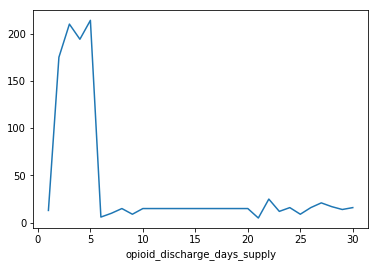

In [240]:
# What was the mean number of days_supply for patients that overdosed and were prescribed opioids?

ct = pd.crosstab(df['prescribed_opioids'],df['opioid_discharge_days_supply'])
ct.iloc[1][1:].plot()
#sns.factorplot(data=ct[0], x='')
df[['overdose','opioid_discharge_days_supply']].groupby('overdose').mean()

### Graph the patient variables against the outcome

Let's see if gender, race and age are associated with the outcome

Text(0,0.5,'Overdose?')

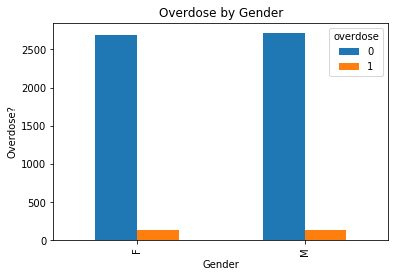

In [241]:
pd.crosstab(patients['gender'],patients['overdose']).plot(kind='bar')
plt.title('Overdose by Gender')
plt.xlabel('Gender')
plt.ylabel('Overdose?')

In [242]:
# Number of Male vs Female overdoses
display(pd.crosstab(patients['gender'],patients['overdose'],margins=True))
display(pd.crosstab(patients['race'],patients['overdose'],margins=True))
display(pd.crosstab(patients['race'],patients['overdose'],normalize='index'))
pd.crosstab(patients['ethnicity'],patients['overdose'],normalize='index')

overdose,0,1,All
gender,,,
F,2696,135,2831
M,2715,132,2847
All,5411,267,5678


overdose,0,1,All
race,,,
asian,425,23,448
black,296,18,314
hispanic,126,7,133
native,63,1,64
other,3,0,3
white,4498,218,4716
All,5411,267,5678


overdose,0,1
race,,
asian,0.948661,0.051339
black,0.942675,0.057325
hispanic,0.947368,0.052632
native,0.984375,0.015625
other,1.000000,0.000000
white,0.953774,0.046226


overdose,0,1
ethnicity,,
african,0.930693,0.069307
american,0.957265,0.042735
american_indian,0.984375,0.015625
arab,1.000000,0.000000
asian_indian,0.972973,0.027027
central_american,1.000000,0.000000
chinese,0.936667,0.063333
dominican,0.971698,0.028302
english,0.942804,0.057196


Text(0,0.5,'Overdose?')

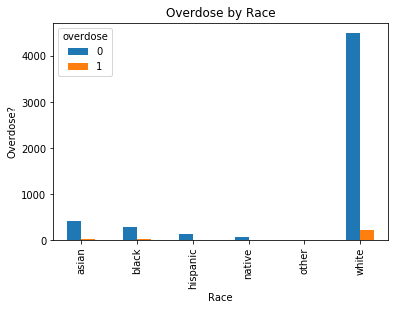

In [243]:
pd.crosstab(patients['race'],patients['overdose']).plot(kind='bar')
plt.title('Overdose by Race')
plt.xlabel('Race')
plt.ylabel('Overdose?')

Age when they visited is pretty uniform until age 60 when it starts to taper off. 


Text(0,0.5,'Frequency')

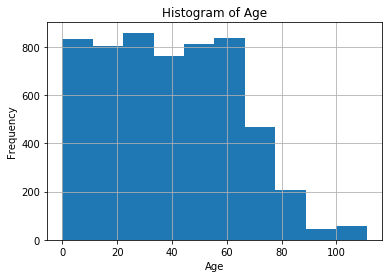

In [244]:
patients['age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

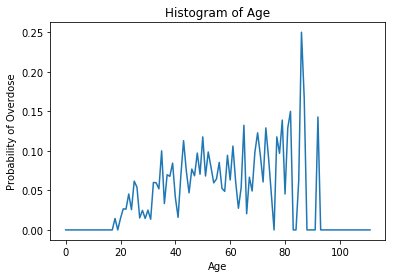

In [245]:
# Graph age_at_visit with probability of overdose
# TODO: FIX

ct = pd.crosstab(df['age'],df['overdose'],normalize='index')[1]

#ct.hist()
ct.plot()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Probability of Overdose')
plt.show()

## Grouping by a variable

We often want to group related rows together and then count the number rows of each type or find the mean of a variable for each row type.

For example, lets count how many encounters each patient has over the timeframe of the data.  We will use the `groupby` function to group on a set of variables.  The operation returns a `groupby` object which doesn't actually group the data but instead acts like a set of instructions telling the DataFrame how to group itself.  We need to apply another function, such as size(), mean() or sum(), to the groups to yield a result.

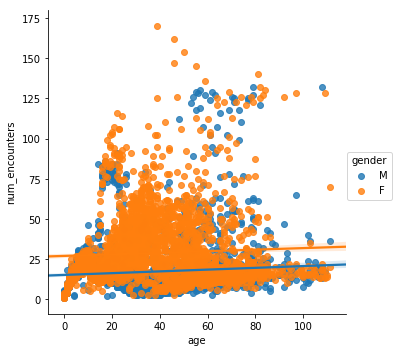

In [246]:
# How many encounters does each patient have?

encs = encounters.groupby(['enc_pat_id']).size()

#display(encs[0:5])
#display(type(encs))

# We can store that information directly into the patients DataFrame since `encs` is indexed by the pat_id
patients = patients.set_index('pat_id')
patients['num_encounters'] = encs
patients = patients.reset_index()

#display(patients.head(5))

sns.lmplot(data=patients,x='age',y='num_encounters',hue='gender')

## For those that overdose, what is the days_supply?

In [247]:
display(df[df['overdose']==1].mean())
df[df['prescribed_opioids']==1].mean()

prior_opioid_abuse_diag          0.700375
age                             52.498127
adult                            1.000000
overdose                         1.000000
prescribed_opioids               0.685393
opioid_discharge_days_supply    10.430712
dtype: float64

prior_opioid_abuse_diag          0.375852
age                             48.654333
adult                            0.958130
overdose                         0.178189
prescribed_opioids               1.000000
opioid_discharge_days_supply     7.284323
dtype: float64

### What are the primary reasons for visit for those that overdosed?

In [248]:
encounters[encounters['enc_pat_id'].isin(patients_that_overdosed)]['enc_reason_description'].value_counts(sort=True)

                                                                         10565
Normal pregnancy                                                           946
Drug overdose                                                              746
Viral sinusitis (disorder)                                                 317
Acute viral pharyngitis (disorder)                                         158
Acute bronchitis (disorder)                                                115
Asthma                                                                      70
Sinusitis (disorder)                                                        46
Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)       32
Streptococcal sore throat (disorder)                                        31
Malignant tumor of colon                                                    18
Concussion with no loss of consciousness                                    17
Fetus with unknown complication                     

## For patients that overdosed, what was the most frequent condition?

In [249]:


conditions[conditions['cond_pat_id'].isin(patients_that_overdosed)]['cond_description'].value_counts(sort=True)

Viral sinusitis (disorder)                                                        317
Acute viral pharyngitis (disorder)                                                158
Drug overdose                                                                     139
Normal pregnancy                                                                  131
Acute bronchitis (disorder)                                                       115
Streptococcal sore throat (disorder)                                               31
Prediabetes                                                                        29
Sprain of ankle                                                                    25
Sinusitis (disorder)                                                               23
Concussion with no loss of consciousness                                           17
Polyp of colon                                                                     15
Chronic sinusitis (disorder)                          

### Get an idea of how a patient progresses through their healthcare

When exploring the data, it helps to visualize what is happening across time.  You can create small functions within the Jupyter notebook and reuse them further down in the notebook.  In this case, we are looping through the encounter data for a patient and print all of the medications and labs (observations) that are associated with the patient.  The function 'display_trajectory' is passed the id for a patient and then prints the information.  We can use this later to further examine data or debug things we don't understand.

In [250]:
pt_id = '3eaed230-1c60-4221-a96c-f6af5d871072'
#pt = patients.query('pat_id == @pt_id')
#pt = patients[patients.pat_id == pt_id].iloc[0]
#pt = patients.loc[pt_id]

def display_trajectory(df,pt_id):
    pt = patients[patients['pat_id']==pt_id]

    display(pt)
    encs = encounters[encounters.enc_pat_id == pt_id]
    #print(encs.shape)
    for i, e in encs.iterrows():
        #dt = df[df['pat_id']==e['enc_pat_id']].iloc[0]
        print('  {:%Y-%m-%d}: {} ({}) ({})'.format(e['enc_date'], e['enc_description'], \
                         e['enc_code'], e['enc_reason_description']))
        meds = medications[medications['med_enc_id'] == e['enc_id']]
        for j, m in meds.iterrows():
            print('     MED: {:%Y-%m-%d}: {} ({}) days_supply={}'.format(m['med_start_date'],  \
                                            m['med_description'], m['med_code'], m['med_days_supply']))
        labs = observations[observations['obs_enc_id'] == e['enc_id']]
        for k, l in labs.iterrows():
            print('     LAB: {:%Y-%m-%d %H:%M}: {} ({}) {} {}'.format(l['obs_date'], l['obs_description'], l['obs_code'], l['obs_value'], l['obs_units']))
            
            

In [251]:
display_trajectory(df,patients.iloc[0].pat_id)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply,num_encounters
0,0a549323-9e08-4843-a61b-d9e0bbf6af72,2017-10-01,,999-52-5697,,,,Gustavo235,Yáñez198,,...,M,St. Paul,359 Kshlerin Well Stillwater Minnesota 55082 US,0,1.0,0,0,0,0,4


  2017-10-01: Encounter for check up (procedure) (185349003) ()
     LAB: 2017-10-01 00:00: Body Height (8302-2) 53.4 cm
     LAB: 2017-10-01 00:00: Body Weight (29463-7) 4.8 kg
  2017-11-05: Encounter for check up (procedure) (185349003) ()
     LAB: 2017-11-05 00:00: Body Height (8302-2) 53.4 cm
     LAB: 2017-11-05 00:00: Body Weight (29463-7) 4.8 kg
     LAB: 2017-11-05 00:00: Diastolic Blood Pressure (8462-4) 77.1 mmHg
     LAB: 2017-11-05 00:00: Systolic Blood Pressure (8480-6) 105.0 mmHg
  2018-01-07: Encounter for check up (procedure) (185349003) ()
     LAB: 2018-01-07 00:00: Body Height (8302-2) 60.3 cm
     LAB: 2018-01-07 00:00: Body Weight (29463-7) 6.7 kg
     LAB: 2018-01-07 00:00: Diastolic Blood Pressure (8462-4) 72.9 mmHg
     LAB: 2018-01-07 00:00: Systolic Blood Pressure (8480-6) 110.1 mmHg
  2018-03-11: Encounter for check up (procedure) (185349003) ()
     LAB: 2018-03-11 00:00: Body Height (8302-2) 66.8 cm
     LAB: 2018-03-11 00:00: Body Weight (29463-7) 9.0 kg


In [252]:
# Who were the patients that overdosed?

pt = df[df['pat_id'].isin(patients_that_overdosed)]

pt.head(10)
#display(pd.DataFrame([pt['first'],pt['last'],pt['marital'],pt['race'],pt['gender'],pt['ethnicity']]).T)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,ethnicity,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
23,519c93d9-1773-4d0c-be57-98cd0c19fe61,1954-12-02,,999-79-6951,S99968196,X27008791X,Mr.,Perry780,Nitzsche158,,...,irish,M,Richfield,771 Huels Bridge Minneapolis Minnesota 55401 US,1,63.0,1,1,0,0
36,0360e97a-20ef-43c1-8dde-da5cd7930cf0,1984-09-25,,999-70-3367,S99922018,X87061277X,Mr.,Gonzalo160,Nieto461,,...,west_indian,M,Ham Lake,873 Crooks Village Apt 23 Rochester Minnesota ...,0,34.0,1,1,0,0
42,2a248682-4a56-486b-a586-9e5509f7bcbe,1983-06-29,,999-87-3013,S99916052,X68980210X,Mrs.,Kristi306,Mertz280,,...,portuguese,F,Brooklyn Center,462 Leannon Ranch Apple Valley Minnesota 55068 US,0,35.0,1,1,0,0
47,5d26b13d-489f-45ba-9bd6-62e972e70acd,1958-02-13,,999-94-2223,S99989717,X28705925X,Mrs.,Noreen211,Schmitt836,,...,chinese,F,Prior Lake,117 Rutherford Well St. Paul Minnesota 55101 US,1,60.0,1,1,1,26
64,ef37d010-366b-49b8-9c70-8559bee471df,1975-04-27,2010-06-04 00:00:00,999-68-3665,S99980755,X17112350X,Mr.,Edgardo196,Kovacek682,,...,american,M,Crystal,957 Hodkiewicz Trace Unit 11 Empireship Minnes...,0,43.0,1,1,1,9
66,e9989367-b139-43cf-a6ec-59e0f26f5d16,1961-02-04,,999-91-6266,S99979959,X78931047X,Mr.,Marvin195,Thiel172,,...,chinese,M,St. Paul,740 Hermiston Vista St. Paul Minnesota 55101 US,1,57.0,1,1,0,0
88,8b03ff3c-5fd9-42d5-9dbe-08fa32507168,1965-05-07,,999-39-9988,S99913056,X65723975X,Mr.,Hunter736,Parker433,,...,south_american,M,Eyota,562 Carter Mews Waseca Minnesota 56093 US,1,53.0,1,1,0,0
104,3c476174-b7ad-4659-846c-9c0b4e5a1a49,1940-07-28,,999-16-9970,S99956663,X18588786X,Mrs.,Deborah357,Shanahan202,,...,irish,F,Hallock,540 Kovacek Trail Unit 73 St. Paul Minnesota 5...,0,78.0,1,1,1,24
153,f0e5606c-f181-4537-8b17-6995afb54c6d,1967-04-11,,999-50-2732,S99942958,X59677614X,Mrs.,Ashley34,Smith67,,...,french,F,Bloomington,113 Lesch Ranch Unit 2 Baxter Minnesota 56401 US,0,51.0,1,1,0,0
199,da3f635f-b798-41de-8352-35ec03a3c524,1933-07-09,,999-66-5025,S99973583,X83382762X,Mr.,Freeman822,Eichmann909,,...,french,M,New Hartfordship,805 Connelly View Unit 93 St. Cloud Minnesota ...,1,85.0,1,1,1,3


In [253]:
# Display the trajectory of one of those patients
pt_id = list(patients_that_overdosed)[1]
display_trajectory(df,pt_id)

,pat_id,birth_date,death_date,ssn,drivers,passport,prefix,first,last,suffix,...,gender,birthplace,address,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply,num_encounters
4129,d1f82541-5af1-4558-8ab8-8dffd251bd1f,1950-02-01,,999-60-6369,S99983966,X62771715X,Mr.,Linwood526,Orn563,,...,M,Waconia,430 Koelpin Dale Apt 32 St. Paul Minnesota 551...,1,68.0,1,1,1,30,45


  2008-08-16: Emergency room admission (50849002) ()
     MED: 2008-08-16: Ibuprofen 200 MG Oral Tablet (310965) days_supply=5
     MED: 2009-01-28: Clopidogrel 75 MG Oral Tablet (309362) days_supply=5
     MED: 2009-01-28: Alteplase 1 MG/ML Injectable Solution (308056) days_supply=5
     MED: 2008-08-16: Acetaminophen 300 MG / HYDROcodone Bitartrate 5 MG [Vicodin] (1310197) days_supply=30
  2009-03-04: Encounter for check up (procedure) (185349003) ()
     LAB: 2009-03-04 00:00: Body Height (8302-2) 182.1 cm
     LAB: 2009-03-04 00:00: Body Weight (29463-7) 122.3 kg
     LAB: 2009-03-04 00:00: Body Mass Index (39156-5) 36.9 kg/m2
     LAB: 2009-03-04 00:00: Diastolic Blood Pressure (8462-4) 100.7 mmHg
     LAB: 2009-03-04 00:00: Systolic Blood Pressure (8480-6) 192.8 mmHg
     LAB: 2009-03-04 00:00: Total Cholesterol (2093-3) 195.2 mg/dL
     LAB: 2009-03-04 00:00: Triglycerides (2571-8) 112.3 mg/dL
     LAB: 2009-03-04 00:00: Low Density Lipoprotein Cholesterol (18262-6) 105.4 mg/dL


In [254]:
# from random import randint, random
# # Add in days_supply
# for i, enc in df.iterrows():
#     if enc['prescribed_opioids']:
#         days_supply = randint(2,15)
#         if enc['overdose']:
#             if random() > 0.30:   # Overdose patients have a 70% chance of a large days supply
#                 days_supply = randint(20,60)      
#     else:
#         days_supply = 0  # They were not prescribed opioids
#     df[enc.name,'opioid_discharge_days_supply'] = days_supply
# display(df[df['overdose']==1].head(20))

In [255]:
# med2 = pd.DataFrame()
# for i, med in medications.iterrows():
#     days_supply = randint(2,15)
#     overdose = med['med_pat_id'] in patients_that_overdosed
#     opioid = med['med_code'] in opioids_rxnorm
#     if overdose & opioid:
#         if random() > 0.30:   # Overdose patients have a 70% chance of a large days supply
#             days_supply = randint(20,60)      
#     med['days_supply'] = days_supply
#     med2.append(med)
# #     print(med)
# #     print(med2.shape)
# #     %%debug
# med2.head(20)

# 6.0 Modeling

We will be using the `scikit-learn` package, which is an open-source library that provides a robust set of machine learning algorithms for Python. It is built upon the core Python scientific stack and has a simple, consistent interface.

<img src="http://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png" width="800px"/>



In [256]:
# Load the modules
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
import random as rnd
from random import random, randint

Most of the models in scikit-learn require the categorical variables be turned into numeric variables.  There are two approaches to this:
1. One Hot Encoding - each item in the categorical variable is turned into its own variable represetnting the presence or abscence of that item.  For example, 'Gender' would turn into 2 variables:  'Gender_M' and 'Gender_F'
2. Label Encoding - assign an integer to each item.  For the 'Gender' variable, 0 might mean Male and 1 might mean Female.

We will use the `LabelEncoder` transformation to change categorical variables into integers.  As a convenience, we can also keep the original (human readable) variable in the Dataframe.

In [257]:
# Let's use the following variables as our initial set of predictors
cat_cols = ['gender', 'marital', 'race', 'ethnicity']
cat_cols_encoded = [c + '_encoded' for c in cat_cols]
numeric_cols = ['prior_opioid_abuse_diag', 'age', 'opioid_discharge_days_supply']
pred_cols = numeric_cols + cat_cols_encoded
target_col = 'overdose'
all_cols = cat_cols+numeric_cols+[target_col]

df_opioids = df[df['prescribed_opioids'] == 1]
print(df_opioids.shape)

# Encode the categorical variables
dfe = df_opioids[cat_cols]
print(dfe.shape)
# Replace missing data with an 'Unknown' category so the missing data will also be encoded
dfe = dfe.replace(np.NaN,'Unknown')

# Encode the categorical variables
encoded = dfe.apply(preprocessing.LabelEncoder().fit_transform)

# Append the non-categorical variables and the encoded variables into a single Dataframe
# Name the new variables as <name>_encoded
dfe = pd.concat([df_opioids[all_cols], encoded.add_suffix('_encoded')],axis=1)

(1027, 23)
(1027, 4)


In [258]:
display(df_opioids.corr())

,prior_opioid_abuse_diag,age,adult,overdose,prescribed_opioids,opioid_discharge_days_supply
prior_opioid_abuse_diag,1.000000,0.088192,0.051809,0.337377,NaN,0.163383
age,0.088192,1.000000,0.359634,0.100082,NaN,-0.014520
adult,0.051809,0.359634,1.000000,0.097340,NaN,-0.174262
overdose,0.337377,0.100082,0.097340,1.000000,NaN,0.455449
prescribed_opioids,NaN,NaN,NaN,NaN,NaN,NaN
opioid_discharge_days_supply,0.163383,-0.014520,-0.174262,0.455449,NaN,1.000000


In [259]:
# df_opioids.loc[:,'prior_opioid_abuse_diag'] = df_opioids['overdose'].apply(lambda x: x if random() > .90 else 1)
# df_opioids.corr()

In [260]:
# Lets try to build a model using this set of variables
pred_cols = ['age', 'opioid_discharge_days_supply', 
             'prior_opioid_abuse_diag', \
             'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']
#pred_cols = ['prior_abuse_diag', 'adult', 'age_at_visit', 'opioid_discharge_days_supply', \
#             'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']

LR_pred_cols = pred_cols
X = dfe[pred_cols].as_matrix()
y = dfe['overdose'].as_matrix()

To remind us of the definitions of recall (sensitivity) and precision (positive predictive value), here is a graphic from Wikipedia:

![Confusion Matrix](Sensitivity-Wikipedia.png)

To quote from Scikit Learn:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

Accuracy is (tp + tn) / N.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [261]:
# Let's try a simple logistic regression model to see how predictive our data is

# https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
# 

LR = LogisticRegression()
result = LR.fit(X,y)

expected = y
predicted = LR.predict(X)

print('\nClassification Report\n',metrics.classification_report(expected, predicted))
print('\nConfusion Matrix\n',metrics.confusion_matrix(expected, predicted))
print('\nAccuracy score =',metrics.accuracy_score(expected, predicted))
print('\nAUC score =',metrics.roc_auc_score(expected, predicted))
print('\nf1 score =',metrics.f1_score(expected, predicted))




Classification Report
              precision    recall  f1-score   support

          0       0.88      0.97      0.92       844
          1       0.72      0.38      0.50       183

avg / total       0.85      0.86      0.85      1027


Confusion Matrix
 [[817  27]
 [113  70]]

Accuracy score = 0.8636806231742941

AUC score = 0.6752615699375858

f1 score = 0.4999999999999999


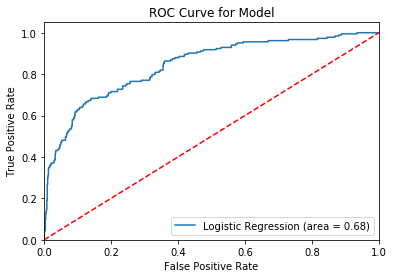

In [262]:
# Lets graph an ROC curve for the model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(y, LR.predict(X))

probs = LR.predict_proba(X)[:,1]
fpr, tpr, thresholds = roc_curve(y, probs)
tpr[1] = tpr[0]

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model')
plt.legend(loc="lower right")
plt.savefig('ROC1.png')


In [263]:
# Now lets try it with Dummy Variables (One Hot Coding)

# 7.0 Model Evaluation

We built a Logistic Regression model that was moderatly predictive of an overdose.  But we trained the model and tested it with our entire data set, which isn't exactly a fair test of the model.

We can split our dataset into a training dataset and a test dataset.  After we train the model using just the training dataset, we will evaluate the model using the test dataset which has data that the model has never seen before.

scikit-learn has a nice function called `train_test_split` that randomly splits our dataset.


In [264]:
# Create the training and test datasets
train, test = train_test_split(dfe, test_size=0.3, random_state=987)

X_train = train[pred_cols].as_matrix()
y_train = train['overdose'].as_matrix()
X_test = test[pred_cols].as_matrix()
y_test = test['overdose'].as_matrix()

In [265]:
LR = LogisticRegression()
result = LR.fit(X_train,y_train)
print(LR)
expected = y_train
predicted = LR.predict(X_train)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

expected = y_test
predicted = LR.predict(X_test)

print('\nClassification Report\n',metrics.classification_report(expected, predicted))
print('\nConfusion Matrix\n',metrics.confusion_matrix(expected, predicted))
print('\nAccuracy score =',metrics.accuracy_score(expected, predicted))
print('\nAUC score =',metrics.roc_auc_score(expected, predicted))
print('\nf1 score =',metrics.f1_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       0.88      0.97      0.92       593
          1       0.72      0.39      0.51       125

avg / total       0.85      0.87      0.85       718

[[574  19]
 [ 76  49]]

Classification Report
              precision    recall  f1-score   support

          0       0.87      0.98      0.92       251
          1       0.81      0.38      0.52        58

avg / total       0.86      0.87      0.85       309


Confusion Matrix
 [[246   5]
 [ 36  22]]

Accuracy score = 0.8673139158576052

AUC score = 0.6796950130512434

f1 score = 0.5176470588235293


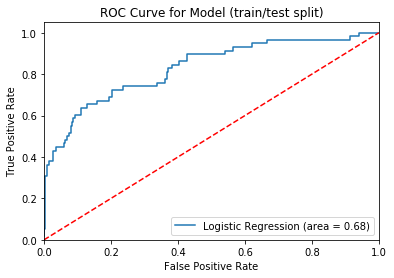

In [266]:
# Lets graph an ROC curve for the model

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
auc = roc_auc_score(y_test, LR.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model (train/test split)')
plt.legend(loc="lower right")
plt.savefig('ROC2.png')

### Cross Validation

Splitting the data into a training dataset and a test dataset has a drawback in that it doesn't allow us to train the model on all of the data.  Another approach is to use k-fold cross validation where we randomly divide the data into k equal sized subsets and then train the model on the remaining k-1 segments of the data and test it on the data that we held out.  The process is repeated k times so that in the end all of the data is used at some point to train the model.  The k model results are averaged to produce a single estimate of model performance.

In [267]:
kfold = model_selection.KFold(n_splits=10, random_state=387)
results = model_selection.cross_val_score(LR, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Model score = %.4f (%.4f)' %(results.mean(), results.std()))


Model score = 0.8323 (0.0938)


# Testing many models

The nice thing about scikit-learn is that most of the models have similar calling signatures so we can just create a list of all of the models we are interested in testing and then invoke each model in a for loop.

We can train each model in turn and then use k-fold cross validate to estimate model performance.

In [268]:
# prepare configuration for cross validation test harness 
# (from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/)

# Make this into a function so we can reuse it later

def eval_models(X, y):
    seed = 543
    # prepare models
    models = []
    models.append(('LR', LogisticRegression(class_weight='balanced')))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM', SVC()))
    models.append(('RF', RandomForestClassifier(n_estimators=100, class_weight='balanced')))
    # evaluate each model in turn
    results = []
    names = []
    #scoring = 'accuracy'
    scoring = 'roc_auc' # others include: 'accuracy', 'f1', 'roc_auc', 
                        # or found here: http://scikit-learn.org/stable/modules/model_evaluation.html
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return results, names

# Execute the function
results, names = eval_models(X_train,y_train)  #TODO:  X,y

LR: 0.836855 (0.089779)
LDA: 0.839609 (0.093437)
KNN: 0.758699 (0.068467)
CART: 0.689028 (0.069852)
NB: 0.847383 (0.076598)
RF: 0.853658 (0.056922)


#### Graphically viewing model performance using a boxplot

None of the models do very well.  LogisticRegression does the best but most of the models have quite a bit of variance in their scores.


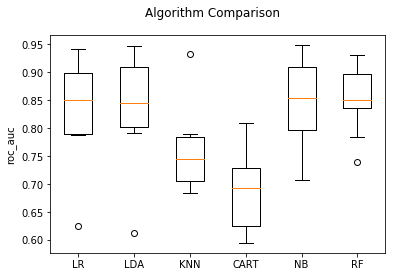

In [269]:
# boxplot algorithm comparison
def plot_perf(names,results):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    plt.ylabel('roc_auc')
    ax.set_xticklabels(names)
    plt.show()
    
plot_perf(names,results)

['prior_opioid_abuse_diag', 'age', 'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']
LR: 0.730251 (0.054270)
LDA: 0.728124 (0.056273)
KNN: 0.559811 (0.049903)
CART: 0.573013 (0.042664)
NB: 0.752395 (0.066510)
RF: 0.665533 (0.034841)


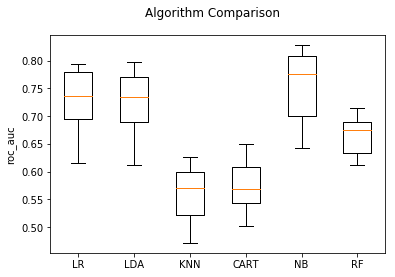

In [270]:
# Can we improve the model by adding some variables?
new_cols = ['prior_opioid_abuse_diag',  'age',  \
             'gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded']
print(new_cols)

X = dfe[new_cols].as_matrix()
y = dfe['overdose'].as_matrix()

X_train = train[new_cols].as_matrix()
y_train = train['overdose'].as_matrix()
X_test = test[new_cols].as_matrix()
y_test = test['overdose'].as_matrix()

results, names = eval_models(X,y)

plot_perf(names,results)

In [271]:
# Display relative importance of each variable
pred_cols = ['gender_encoded', 'marital_encoded', 'race_encoded', 'ethnicity_encoded', 'age', 
               'prior_opioid_abuse_diag', 'opioid_discharge_days_supply']
model = RandomForestClassifier()
model.fit(dfe[pred_cols], dfe['overdose'])

# display the relative importance of each attribute
display(pd.DataFrame(list(zip(pred_cols,model.feature_importances_))))



,0,1
0,gender_encoded,0.021026
1,marital_encoded,0.040442
2,race_encoded,0.024450
3,ethnicity_encoded,0.138147
4,age,0.240544
5,prior_opioid_abuse_diag,0.072544
6,opioid_discharge_days_supply,0.462848


In [272]:
display(dfe[LR_pred_cols].head(1))

,age,opioid_discharge_days_supply,prior_opioid_abuse_diag,gender_encoded,marital_encoded,race_encoded,ethnicity_encoded
3,57.0,3,0,0,1,4,7


In [273]:
# Show how to use the resulting model to predict opioid overdose

new_patient = [45,1,0,1,4,7]

pred = LR.predict(np.asmatrix(new_patient))
if pred[0] == 0:
    print('No overdose risk.')
elif pred[0] == 1:
    print('Overdose risk.')

ValueError: X has 6 features per sample; expecting 7